In [61]:
# For reading our data set
import pandas
# For lots of great things.
import numpy as np
# To make our plots.
import matplotlib.pyplot as plt
%matplotlib inline
# Because sympy and LaTeX make
# everything look wonderful!
from sympy import *
init_printing(use_latex=True)
from IPython.display import display
# We will use this to check our implementation...
from sklearn.decomposition import PCA
# For building our net
import keras
# Need this for LabelEncoder
from sklearn import preprocessing

## Read in data

In [62]:
student_data = np.array(pandas.read_table("./student-por.csv",
delimiter=";", header=0))

student_data

array([['GP', 'F', 18, ..., 0, 11, 11],
       ['GP', 'F', 17, ..., 9, 11, 11],
       ['GP', 'F', 15, ..., 12, 13, 12],
       ...,
       ['MS', 'F', 18, ..., 11, 12, 9],
       ['MS', 'M', 17, ..., 10, 10, 10],
       ['MS', 'M', 18, ..., 10, 11, 11]], dtype=object)

# Data Cleanup

## Shuffle data

In [63]:
np.random.shuffle(student_data)

student_data

array([['GP', 'F', 18, ..., 17, 17, 18],
       ['MS', 'M', 16, ..., 10, 11, 11],
       ['GP', 'M', 16, ..., 15, 13, 13],
       ...,
       ['GP', 'F', 17, ..., 13, 13, 13],
       ['GP', 'F', 16, ..., 12, 13, 13],
       ['GP', 'M', 16, ..., 12, 11, 12]], dtype=object)

## Numerically classify scores

In [64]:
scores = student_data[:,32]

In [65]:
for i in range(len(scores)):
    if(scores[i] > 18):
        scores[i] = 4
    elif(scores[i] > 16):
        scores[i] = 3
    elif(scores[i] > 14):
        scores[i] = 2
    elif(scores[i] > 12):
        scores[i] = 1
    else:
        scores[i] = 0

In [66]:
for i in range(len(scores)):
    student_data[i,32] = scores[i]
    
student_data

array([['GP', 'F', 18, ..., 17, 17, 3],
       ['MS', 'M', 16, ..., 10, 11, 0],
       ['GP', 'M', 16, ..., 15, 13, 1],
       ...,
       ['GP', 'F', 17, ..., 13, 13, 1],
       ['GP', 'F', 16, ..., 12, 13, 1],
       ['GP', 'M', 16, ..., 12, 11, 0]], dtype=object)

## Encoding non-numeric data to integers

In [67]:
# one student sample
student_data[0,:]

array(['GP', 'F', 18, 'R', 'LE3', 'T', 1, 1, 'at_home', 'other',
       'reputation', 'mother', 2, 4, 0, 'no', 'yes', 'no', 'yes', 'yes',
       'yes', 'no', 'no', 5, 2, 2, 1, 1, 3, 2, 17, 17, 3], dtype=object)

In [68]:
le = preprocessing.LabelEncoder()

# columns that hold non-numeric data
indices = np.array([0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])

# transform the non-numeric data in these columns to integers
for i in range(len(indices)):
    column = indices[i]
    le.fit(student_data[:,column])
    student_data[:,column] = le.transform(student_data[:,column])

In [69]:
student_data[0,:]

array([0, 0, 18, 0, 1, 1, 1, 1, 0, 2, 3, 1, 2, 4, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 5, 2, 2, 1, 1, 3, 2, 17, 17, 3], dtype=object)

## Encoding 0's to -1 for binomial data.

In [70]:
# columns that hold binomial data
indices = np.array([0,1,3,4,5,15,16,17,18,19,20,21,22])

# change 0's to -1's
for i in range(len(indices)):
    j = indices[i]
    feature = student_data[:,j]
    feature = np.where(feature==0, -1, feature)
    student_data[:,j] = feature

In [71]:
student_data[0,:]

array([-1, -1, 18, -1, 1, 1, 1, 1, 0, 2, 3, 1, 2, 4, 0, -1, 1, -1, 1, 1,
       1, -1, -1, 5, 2, 2, 1, 1, 3, 2, 17, 17, 3], dtype=object)

## Standardizing the nominal and numerical data.

In [72]:
scaler = preprocessing.StandardScaler()

In [73]:
temp = student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]]
Standardized = scaler.fit_transform(temp)

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [74]:
print('Mean:', round(Standardized.mean()))
print('Standard deviation:', Standardized.std())

Mean: -0.0
Standard deviation: 1.0


In [75]:
student_data[:,[2,6,7,8,9,10,11,12,13,14,23,24,25,26,27,28,29,30,31]] = Standardized

In [76]:
student_data[0,:]

array([-1, -1, 1.0316951635937113, -1, 1, 1, -1.3360393847765342,
       -1.1888322936014033, -1.556452535644832, -0.2607275884816344,
       1.5846512634547596, 0.3326475069742608, 0.57671799145725,
       2.4965758093572377, -0.3743051181921297, -1, 1, -1, 1, 1, 1, -1,
       -1, 1.1197481596133516, -1.1237713349052476, -1.0085456232078611,
       -0.5435553304269218, -0.9976946599159401, -0.3710421971530383,
       -0.3578630461124801, 2.041786228992247, 1.8650494739652166, 3],
      dtype=object)

## Convert results to one-hot encoding

In [77]:
# final grades
results = student_data[:,32]

# all unique values for final grades (0-4)
possible_results = Matrix(np.unique(student_data[:,32])).T

In [78]:
# one-hot encode final grades which will be used as our output
y = keras.utils.to_categorical(results,len(possible_results))

In [79]:
y[0:5]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Model Building

In [80]:
# our input, all features except final grades
x = student_data[:,0:32]

In [81]:
# feed-forward, sequential model
model = keras.Sequential()

# specify input and output size
input_size = x.shape[1]
output_size = y.shape[1]

In [82]:
# create the hidden layer (input?)
model.add(keras.layers.Dense(800,input_dim=input_size,activation='relu'))

In [83]:
model.add(keras.layers.Dense(400,activation='relu'))

In [84]:
# output layer
model.add(keras.layers.Dense(output_size,activation='softmax'))

In [85]:
# compile - why using adamax?
model.compile(loss='categorical_crossentropy',
              optimizer='adamax', 
              metrics=['accuracy'])

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 800)               26400     
_________________________________________________________________
dense_8 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2005      
Total params: 348,805
Trainable params: 348,805
Non-trainable params: 0
_________________________________________________________________


# Training the network

In [87]:
# split data into training and testing data
x_train = x[0:518,:]
x_test = x[519:649,:]

y_train = y[0:518,:]
y_test = y[519:649,:]

In [88]:
# train on training data!
history = model.fit(x_train, y_train,
                    batch_size = 32, 
                    epochs = 7, 
                    verbose = 0, 
                    validation_split = 0.2)

In [89]:
# validate using data the network hasn't seen before (testing data)
# check it's effectiveness
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5240104313080127
Test accuracy: 0.7692307692307693


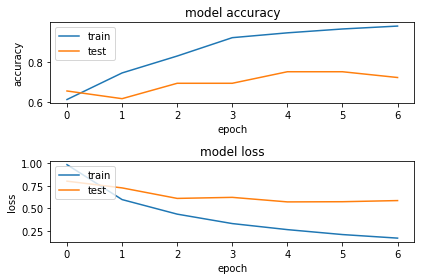

In [90]:
# plot the data

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc ='upper left')

plt.tight_layout()
plt.show()